In [ ]:
import math
import pytesseract
from PIL import Image

import tensorflow as tf
import numpy as np
import os, sys, cv2

CTPNDIR=os.path.join(sys.path[0],'text-detection-ctpn')
sys.path.append(CTPNDIR)

from lib.networks.factory import get_network
from lib.fast_rcnn.config import cfg,cfg_from_file
from lib.fast_rcnn.test import test_ctpn
from lib.utils.timer import Timer
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg

def ctpn_init():

    cfg_from_file(os.path.join(CTPNDIR,'ctpn', 'text.yml'))

    # init session
    config = tf.ConfigProto(allow_soft_placement=True)
    sess = tf.Session(config=config)
    # load network
    net = get_network("VGGnet_test")
    # load model
    #print(('Loading network {:s}... '.format("VGGnet_test")), end=' ')
    saver = tf.train.Saver()

    try:
        ckpt = tf.train.get_checkpoint_state(cfg.TEST.checkpoints_path)
        #print('Restoring from {}...'.format(ckpt.model_checkpoint_path), end=' ')
        saver.restore(sess, ckpt.model_checkpoint_path)
        #print('done')
    except:
        raise 'Check your pretrained {:s}'.format(ckpt.model_checkpoint_path)

    im = 128 * np.ones((300, 300, 3), dtype=np.uint8)
    for i in range(2):
        _, _ = test_ctpn(sess, net, im)

    return sess,net

def resize_im(im, scale, max_scale=None):
    f=float(scale)/min(im.shape[0], im.shape[1])
    if max_scale!=None and f*max(im.shape[0], im.shape[1])>max_scale:
        f=float(max_scale)/max(im.shape[0], im.shape[1])
    return cv2.resize(im, None,None, fx=f, fy=f,interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img,boxes,scale,basename):
    #INTERDIR = 'text_box'
    #if not os.path.exists(INTERDIR):
        #os.mkdir(INTERDIR)

    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0]/scale),int(box[2]/scale),int(box[4]/scale),int(box[6]/scale))
        min_y = min(int(box[1]/scale),int(box[3]/scale),int(box[5]/scale),int(box[7]/scale))
        max_x = max(int(box[0]/scale),int(box[2]/scale),int(box[4]/scale),int(box[6]/scale))
        max_y = max(int(box[1]/scale),int(box[3]/scale),int(box[5]/scale),int(box[7]/scale))

    img=cv2.resize(img, None, None, fx=1.0/scale, fy=1.0/scale, interpolation=cv2.INTER_LINEAR)
    #output_path = os.path.join(INTERDIR,basename)
    output_path = 'BOX_' + basename
    cv2.imwrite(output_path, img)

def boxes_norm(boxes,scale):

    new_boxes=[]
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue

        min_x = min(int(box[0]/scale),int(box[2]/scale),int(box[4]/scale),int(box[6]/scale))
        min_y = min(int(box[1]/scale),int(box[3]/scale),int(box[5]/scale),int(box[7]/scale))
        max_x = max(int(box[0]/scale),int(box[2]/scale),int(box[4]/scale),int(box[6]/scale))
        max_y = max(int(box[1]/scale),int(box[3]/scale),int(box[5]/scale),int(box[7]/scale))

        new_boxes.append((min_x,min_y,max_x,max_y))

    return new_boxes

def ctpn_run(sess, net, img, basename):

    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    scores, boxes = test_ctpn(sess, net, img)

    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    draw_boxes(img, boxes, scale,basename)
    boxes = boxes_norm(boxes,scale)
    return boxes


# Main

sess,net = ctpn_init()

img_path = './OCR_TEST.jpg'
img = cv2.imread(img_path)
basename = os.path.basename(img_path)

boxes = ctpn_run(sess, net, img, basename)
count = 0
for box in boxes:
    img = img[(box[1]):(box[3]), box[0]:box[2]]
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, threshold = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #blur = cv2.blur(threshold,(2,2))
    #cv2.imwrite(str(count)+'tmp.png',blur)
    
    #text = pytesseract.image_to_string(Image.fromarray(text_region), 'eng', config='--psm 7')
    text = pytesseract.image_to_string(Image.fromarray(img), 'chi_sim+eng', config='--psm 6')
    print text

In [1]:
import matplotlib.pylab as plt
import cv2
%matplotlib inline

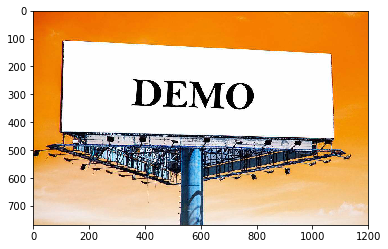

In [3]:
img = cv2.imread('./OCR_TEST.jpg')
plt.imshow(img)

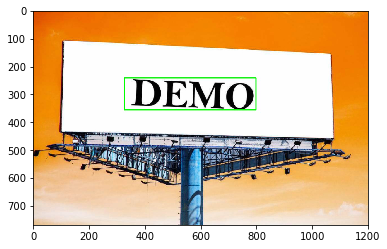

In [4]:
text_box = cv2.imread('./BOX_OCR_TEST.jpg')
plt.imshow(text_box)